In [ ]:
import pandas as pd
import json
import os 
from collections import defaultdict
import matplotlib.pyplot as plt

In [53]:
ids = []
for file_name in os.listdir('../haystack/irrelevant'):
    if file_name.endswith('.txt'):
        file_id = os.path.splitext(file_name)[0]  # Extract the file name without extension
        ids.append(file_id)
print(ids)

['121', '122', '123', '124', '155', '156', '157', '160', '162', '163', '164', '165', '166', '167', '168', '170', '172', '173', '175', '180', '182', '183', '184', '185', '187', '189', '192', '193', '196', '198', '199', '377', '380', '384', '391', '393', '401', '402', '403', '408', '409', '410', '411', '420', '421', '422', '423', '424', '427', '43', '430', '432', '433', '435', '436', '437', '438', '439', '44', '441', '442', '444', '446', '448', '449', '452', '453', '532', '535', '536', '539', '576', '577', '578', '579', '580', '586', '587', '588', '589', '590', '92', '95', '96']


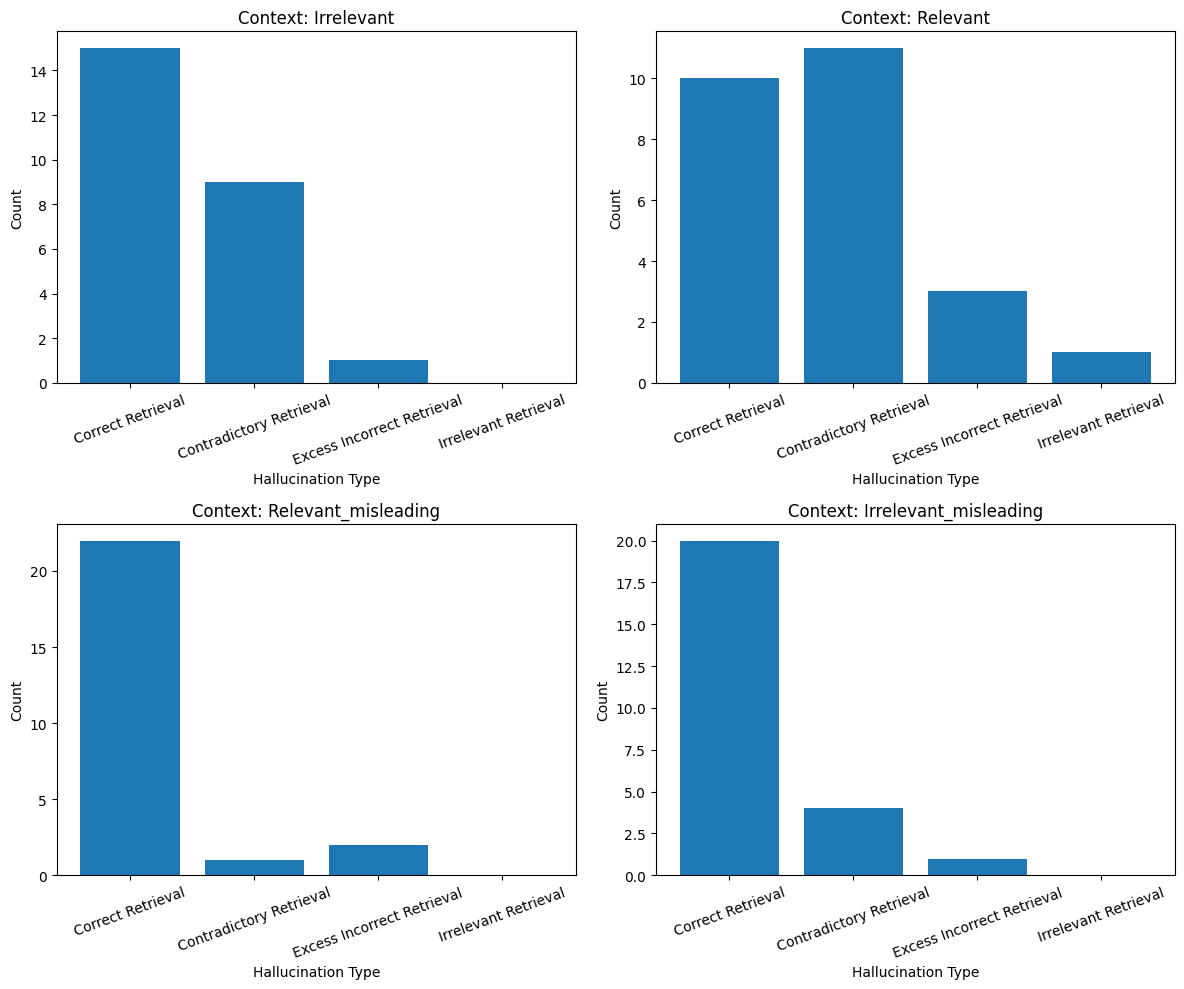

In [ ]:
all_rows = []

for id in ids:
    try:
        with open(f"updated_unique_responses/{id}.json", "r") as f:
            data = json.load(f)
            for category, entries in data.items():
                for entry in entries:
                    entry['context_category'] = category
                    entry['id'] = id
                    all_rows.append(entry)

    except FileNotFoundError:
            pass

df = pd.DataFrame(all_rows)
df['scores'] = df['hallucination_type'].apply(
    lambda x: 100.0 if x == 'Correct Retrieval' else 0.0
)

# row: depth, col: context length
depth_percentages_set = set(df['depth_percent'])
context_length_set = set(df['context_length'])

score_matrix = pd.DataFrame(0, index=sorted(list(depth_percentages_set)), columns=sorted(list(context_length_set)))

score_mean_matrices = {
    "irrelevant": score_matrix.copy(),
    "relevant": score_matrix.copy(),
    "relevant_misleading": score_matrix.copy(),
    "irrelevant_misleading": score_matrix.copy()
}

score_var_matrices = {
    "irrelevant": score_matrix.copy(),
    "relevant": score_matrix.copy(),
    "relevant_misleading": score_matrix.copy(),
    "irrelevant_misleading": score_matrix.copy()
}

bar_charts = {
    "irrelevant": None,
    "relevant": None,
    "relevant_misleading": None,
    "irrelevant_misleading": None
}
     
for context_key in score_mean_matrices.keys():
    bar_chart_df = df[df['context_category'] == context_key]
    hallucination_counts = bar_chart_df['hallucination_type'].value_counts().to_dict()
    bar_charts[context_key] = defaultdict(lambda: 0, hallucination_counts)
    
    for depth in depth_percentages_set:
        for context_length in context_length_set:
            filtered_df = df[(df['depth_percent'] == depth) & (df['context_length'] == context_length) & (df['context_category'] == context_key)]

            if not filtered_df.empty:
                avg_val = filtered_df['scores'].mean()
                # using population variance
                var_val = filtered_df['scores'].var(ddof=0)
                score_mean_matrices[context_key].loc[depth, context_length] = avg_val
                score_var_matrices[context_key].loc[depth, context_length] = var_val

# Assuming bar_charts has exactly 4 items
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 rows x 2 cols of subplots
axes = axes.flatten()  # Flatten to make it easier to loop through

for idx, (context_key, context_values) in enumerate(bar_charts.items()):
    ax = axes[idx]
    x_axis = ["Correct Retrieval", "Contradictory Retrieval", "Excess Incorrect Retrieval", "Irrelevant Retrieval"]
    ax.bar(x_axis, [context_values[key] for key in x_axis])
    ax.set_xlabel("Hallucination Type")
    ax.set_ylabel("Count")
    ax.set_title("Context: " + context_key.capitalize())
    ax.tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.show()


In [47]:
bar_charts.keys()

dict_keys(['irrelevant', 'relevant', 'relevant_misleading', 'irrelevant_misleading'])

In [ ]:
df
